# YOUR PROJECT TITLE

### Ideer (inspireret af Samf B hjemmeopgave 2)
- Brug DST: tabel AUS07 til at vise udviklingen i bruttoledighed underinddelt i køn (stablet søjler evt. med linje der angive i alt)
- Brug DST: tabel AUS07 til at vise udviklingen i bruttoledighed underinddelt i alder
- Arbejdsstyrke?
- Brug DST: tabel AUS08 til at vise udviklingen i bruttoledighed underinddelt i region
- Evt. kig på ’discouraged worker-effect’ (ledige der trækker sig ud af arbejdsmarkedet ved høj arbejdsløshed). Her skal man se på om beskæftigelsen er faldet mere end ledigheden (bruttoledighed = RAM - find tabel - og (årlig)beskæftigelse = NABB19 -> findes der en statistik der opgører månedlig beskæftigelse? RAM skal sammenlignes med Nationalregnskabet)
- Brug DST: tabel EKSP04 (ledige og nyopslåede stillinger på jobnet) til at illustrere efterspørgslen efter arbejdskraft.
- Brug DST: tabel AUP01 (fuldtidsledige som pct. af arbejdsstyrken fordelt på alder og område)
- Brug DST: LBESK03 lønmodtagere efter branche. Udviklingen i ledigheden på tværs af erhver-agtigt


https://www.dst.dk/da/Statistik/nyt/NytHtml?cid=31501
 

Lav en slags tidslinje over begivenheder der kan have haft effekt på lededen/beskæftigelse. Eventuelt inkluder dem direkte i grafer


**Import packages**

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import ipywidgets as widgets
plt.style.use('seaborn-whitegrid')
import datetime as dt
#from matplotlib_venn import venn2 # install with pip install matplotlib-venn

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject
#pip install git+https://github.com/elben10/pydst 
#to run this the above code needs to be installed in terminal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

**Import package Pydst to get data using an API from Statistics Denmark**

In [2]:
import pydst

In [3]:
Dst = pydst.Dst(lang='en')
#Dst.get_tables(subjects=['INDKP107'])
Dst.get_subjects()
tables = Dst.get_tables(subjects=['04'])

**Getting data from table: AUS07**

In [4]:
data_aus07 = tables[tables.id=='AUS07']
data_aus07

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
113,AUS07,Unemployed persons (seasonally adjusted),-,2021-03-04 08:00:00,2007M01,2021M01,True,"[benefits, sex and age, seasonal adjustment an..."


In [5]:
aus_vars = Dst.get_variables(table_id='AUS07')
aus_vars

,id,text,elimination,time,values
0,YD,"benefits, sex and age",False,False,"[{'id': 'TOT', 'text': 'Gross unemployment'}, ..."
1,SAESONFAK,seasonal adjustment and actual figures,False,False,"[{'id': '9', 'text': 'Seasonally adjusted figu..."
2,Tid,time,False,True,"[{'id': '2007M01', 'text': '2007M01'}, {'id': ..."


In [6]:
for id in ['YD', 'SAESONFAK','Tid']:
    print(id)
    values = aus_vars.loc[aus_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')
#Bruttoledige består af de ikke-aktiverede (nettoledige) og aktiverede ledige.

YD
 id = TOT, text = Gross unemployment
 id = NET, text = Net unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = AKI, text = Activation total
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
 id = MEN, text = Men
 id = KVR, text = Women
 id = U25, text = 16-24 years
 id = O25, text = 25-29 years
 id = O30, text = 30-39 years
 id = O40, text = 40-49 years
 id = O50, text = 50-59 years
 id = O60, text = 60 years and more
SAESONFAK
 id = 9, text = Seasonally adjusted figures in percent of the labour force
 id = 10, text = Seasonally adjusted
 id = 22, text = Enumerated actual figures  in percent of the labour force
 id = 24, text = Enumerated actual figures
Tid
 id = 2007M01, text = 2007M01
 id = 2007M02, text = 2007M02
 id = 2007M03, text = 2007M03
 id = 2007M04, text = 2007M04
 id = 20

In [7]:
variables = {'YD': ['TOT'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07 = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07 = aus07.iloc[:,1:] #dropping column 'YD'
aus07.head()

,SAESONFAK,TID,INDHOLD
0,Seasonally adjusted,2008M11,79298.9
1,Seasonally adjusted,2008M12,85631.1
2,Seasonally adjusted,2009M01,92165.2
3,Seasonally adjusted,2009M02,101461.8
4,Seasonally adjusted,2009M03,111313.7


Drop column ID

In [8]:
#new_api11 = pd.DataFrame(new_api1)
#new_api11.head(10)

**Getting data from table: LBESK03**

In [9]:
data_lbesk03 = tables[tables.id=='LBESK03']
data_lbesk03
lbesk_vars = Dst.get_variables(table_id='LBESK03')
lbesk_vars

,id,text,elimination,time,values
0,BRANCHEDB071038,industry (DB07 10- and 19-grouping),True,False,"[{'id': 'TOT', 'text': 'TOT Industry, total'},..."
1,Tid,time,False,True,"[{'id': '2008M01', 'text': '2008M01'}, {'id': ..."


In [10]:
for id in ['BRANCHEDB071038','Tid']:
    print(id)
    values = lbesk_vars.loc[lbesk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')
#Bruttoledige består af de ikke-aktiverede (nettoledige) og aktiverede ledige.

BRANCHEDB071038
 id = TOT, text = TOT Industry, total
 id = 1, text = 1 Agriculture, forestry and fishing
 id = A, text = A Agriculture, forestry and fishing
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = B, text = B Mining and quarrying
 id = C, text = C Manufacturing
 id = D, text = D Electricity, gas, steam and air conditioning supply
 id = E, text = E Water supply, sewerage and waste management
 id = 3, text = 3 Construction
 id = F, text = F Construction
 id = 4, text = 4 Trade and transport etc.
 id = G, text = G Wholesale and retail trade
 id = H, text = H Transportation
 id = I, text = I Accommodation and food service activities
 id = 5, text = 5 Information and communication
 id = J, text = J Information and communication
 id = 6, text = 6 Financial and insurance
 id = K, text = K Financial and insurance
 id = 7, text = 7 Real estate
 id = L, text = L Real estate activities
 id = 8, text = 8 Other business services
 id = M, text = M Knowledge

In [122]:
variables = {'BRANCHEDB071038': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'X'],'Tid': ['*']}
lbesk03 = Dst.get_data(table_id = 'LBESK03', variables = variables)
lbesk03.head()

#variables = {'BRANCHEDB071038': ['TOT'],'Tid': ['*']}
#lbesk031 = Dst.get_data(table_id = 'LBESK03', variables = variables)
#lbesk031.head()

,BRANCHEDB071038,TID,INDHOLD
0,"A Agriculture, forestry and fishing",2018M09,42578
1,B Mining and quarrying,2018M09,4616
2,C Manufacturing,2018M09,305186
3,"D Electricity, gas, steam and air conditioning...",2018M09,10412
4,"E Water supply, sewerage and waste management",2018M09,11745


**Getting data from table: LSK01**

In [12]:
data_lsk01 = tables[tables.id=='LSK01']
data_lsk01
lsk_vars = Dst.get_variables(table_id='LSK01')
lsk_vars

,id,text,elimination,time,values
0,BRANCHE,industry,True,False,"[{'id': '0', 'text': 'Total'}, {'id': '2', 'te..."
1,ENHED,unit,False,False,"[{'id': 'LS', 'text': 'Job vacancies (number)'..."
2,STØRRELSE,size,True,False,"[{'id': '000', 'text': 'Workplaces total'}, {'..."
3,Tid,time,False,True,"[{'id': '2010K1', 'text': '2010Q1'}, {'id': '2..."


In [13]:
for id in ['BRANCHE','ENHED', 'Tid']:
    print(id)
    values = lsk_vars.loc[lsk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

BRANCHE
 id = 0, text = Total
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = 3, text = 3 Construction
 id = 4, text = 4 Trade and transport etc.
 id = 5, text = 5 Information and communication
 id = 6-7, text = 6-7 Financial, insurance and real estate
 id = 8, text = 8 Other business services
ENHED
 id = LS, text = Job vacancies (number)
 id = ALS, text = Job vacancy rate (per cent)
Tid
 id = 2010K1, text = 2010Q1
 id = 2010K2, text = 2010Q2
 id = 2010K3, text = 2010Q3
 id = 2010K4, text = 2010Q4
 id = 2011K1, text = 2011Q1
 id = 2011K2, text = 2011Q2
 id = 2011K3, text = 2011Q3
 id = 2011K4, text = 2011Q4
 id = 2012K1, text = 2012Q1
 id = 2012K2, text = 2012Q2
 id = 2012K3, text = 2012Q3
 id = 2012K4, text = 2012Q4
 id = 2013K1, text = 2013Q1
 id = 2013K2, text = 2013Q2
 id = 2013K3, text = 2013Q3
 id = 2013K4, text = 2013Q4
 id = 2014K1, text = 2014Q1
 id = 2014K2, text = 2014Q2
 id = 2014K3, text = 2014Q3
 id = 2014K4, text = 2014Q4
 id = 2015K1, t

In [14]:
variables = {'BRANCHE': ['*'], 'Enhed': ['LS'], 'Tid': ['*']}
lsk01 = Dst.get_data(table_id = 'LSK01', variables = variables)
lsk01.head()

,BRANCHE,ENHED,TID,STØRRELSE,INDHOLD
0,Total,Job vacancies (number),2010Q1,Workplaces total,19094.0
1,"2 Manufacturing, mining and quarrying, and uti...",Job vacancies (number),2010Q1,Workplaces total,2854.0
2,3 Construction,Job vacancies (number),2010Q1,Workplaces total,1362.0
3,4 Trade and transport etc.,Job vacancies (number),2010Q1,Workplaces total,7857.0
4,5 Information and communication,Job vacancies (number),2010Q1,Workplaces total,1666.0


# Merge data sets

In [165]:
dstmerge = pd.merge(aus07, lbesk03, how='outer', on=['TID']);
dstmerge.rename(columns = {'INDHOLD_x': 'Unemployed', 'INDHOLD_y': 'Employed', 'TID': 'TIME', 'BRANCHEDB071038': 'BRANCH'}, inplace = True)
#dstmerge.pd.date_to_time['TIME']

dstmerge['TIME'] = dstmerge['TIME'].str.replace(r'\D', '')
dstmerge['YEAR'] = dstmerge['TIME'].str[:4]
dstmerge['MD'] = dstmerge['TIME'].str[-2:]
dstmerge['branch'] = dstmerge['BRANCH'].str[:1]
dstmerge.head()

#unemployed - gross

,SAESONFAK,TIME,Unemployed,BRANCH,Employed,YEAR,MD,branch
0,Seasonally adjusted,200811,79298.9,"A Agriculture, forestry and fishing",38581.0,2008,11,A
1,Seasonally adjusted,200811,79298.9,B Mining and quarrying,4780.0,2008,11,B
2,Seasonally adjusted,200811,79298.9,C Manufacturing,363401.0,2008,11,C
3,Seasonally adjusted,200811,79298.9,"D Electricity, gas, steam and air conditioning...",12108.0,2008,11,D
4,Seasonally adjusted,200811,79298.9,"E Water supply, sewerage and waste management",11739.0,2008,11,E


In [144]:
dstmerge['YEAR'] = dstmerge['YEAR'].astype(str).astype(int)
#dstmerge.loc[dstmerge['YEAR'] > 2007, :]
#drop 2007
#dstmerge['date']= pd.to_datetime(dstmerge['TIME'], format='%y%m%d')
#dstmerge.head()


In [145]:
dstmerge.dtypes

SAESONFAK      object
TIME           object
Unemployed    float64
BRANCH         object
Employed      float64
YEAR            int64
MD             object
dtype: object

In [161]:
dstmerge['YEAR'] = dstmerge.loc[dstmerge['YEAR'] > 2007, :]

In [137]:
dstmerge.dtypes

SAESONFAK      object
TIME           object
Unemployed    float64
BRANCH         object
Employed      float64
YEAR           object
MD             object
dtype: object

In [91]:
#dstmerge['MonthYear'] = pd.to_datetime(dstmerge[['YEAR', 'MD']].assign(Day=1)).dt.strftime('%Y-%m')

# Data Analysis

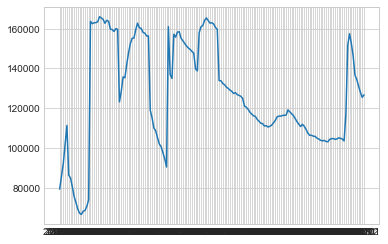

In [124]:
x = dstmerge['TIME']
y = dstmerge['Unemployed']
plt.plot(x,y)
plt.show()

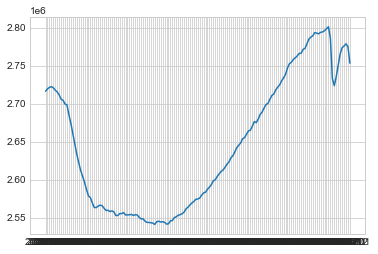

In [109]:
#bruger et subsæt af beskæftigede med total = industry
z = lbesk031['TID']
k = lbesk031['INDHOLD']
plt.plot(z,k)
plt.show()

In [160]:
#lave liste med unikke værdier for brancher
branch_unique = dstmerge.BRANCH.unique()
print(branch_unique)

['A Agriculture, forestry and fishing' 'B Mining and quarrying'
 'C Manufacturing' 'D Electricity, gas, steam and air conditioning supply'
 'E Water supply, sewerage and waste management' 'F Construction'
 'G Wholesale and retail trade' 'H Transportation'
 'I Accommodation and food service activities'
 'J Information and communication' 'K Financial and insurance'
 'L Real estate activities' 'M Knowledge-based services'
 'N Travel agent, cleaning, and other operationel services'
 'O Public administration, defence and compulsory social security'
 'P Education' 'Q Human health and social work'
 'R Arts, entertainment and recreation activities'
 'S Other service activities etc.' 'X Activity not stated' nan]


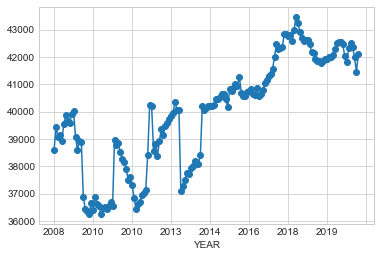

In [173]:
import ipywidgets as widgets 

def plot_employ(dstmerge, branch1):
    I = dstmerge['branch'] == branch1
    ax = dstmerge.loc[I,:].plot(x='YEAR', y='Employed', style='-o', legend=False)

widgets.interact(plot_employ,
    dstmerge = widgets.fixed(dstmerge),
    branch1 = widgets.Dropdown(description='Branch', 
                                options=dstmerge.branch.unique(),
                                value='A')
);

In [155]:
def _plot_timeseries(dataframe, variable, years):
    
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    dataframe.loc[:,['YEAR']] = pd.to_numeric(dataframe['YEAR'])
    I = (dataframe['YEAR'] >= years[0]) & (dataframe['YEAR'] <= years[1])
    
    x = dataframe.loc[I,'YEAR']
    y = dataframe.loc[I,variable]
    ax.plot(x,y)
    
    ax.set_xticks(list(range(years[0], years[1] + 1, 5)))    
    
def plot_timeseries(dataframe):
    
     widgets.interact(_plot_timeseries, 
     dataframe = widgets.fixed(dataframe),
     variable = widgets.Dropdown(
         description='variable', 
         options=dstmerge.BRANCH.unique(), 
         value='A'),
     years=widgets.IntRangeSlider(
         description="years",
         min=2008,
         max=2020,
         value=[2008, 2020],
         continuous_update=False,
      )                 
); 

In [156]:
plot_timeseries(dstmerge)

TraitError: Invalid selection: value not found

**Emne: Vi ønsker at analysere arbejdsstyrken (de beskæftigede samt de ledige)**
* hvad sker der under corona?
* hvor mange bliver ledige, ryger de i aktivering?
* er der nogen som under corona (arbejdsstyrken?)
* efterspørgsel - ledige stillinger

Periode: før/efter corona (sammenligner 2019 med 2020)
1. Beskæftigelse + ledige (overordnet)
* 
2. Ledige 
* aktivering osv.
* efterspørgsel -> ledige stillinger (brancher)
* udgangspunkt i f.eks. brancher
3. Beskæftigelse
* branche før/efter corona

1. Udviklingen i bruttoledighed (mange år) (AUS07)
* interaktiv graf (ps 3)
* alder / køn evt.

2. Udviklingen i beskæftigelse (LBSK03)
* branche

3. Efterspørgsel
* vis ledige stillinger (LSK01)

4. konklusion







# Conclusion

ADD CONCISE CONLUSION.